# Model Fitness - Predictive Analysis

# Table of contents   <a id='back'></a>
1.[Introduction](#intro)  
2.[Steps](#steps)  
3.[Data Preprocessing](#preprocess)    
4.[Exploratory Data Analysis](#eda)   
5.[Build Logistic Regression model](#logistic)    
6.[Build Random Forest model](#random)  
7.[Metrics for the model](#metrics)  
8.[Agglomerative Heirarchial Clustering](#hierarchial)  
9.[K Means Clustering](#kmeans)   
10.[Churn rate](#churnrate)  
11.[Final Conclusion](#end)


<a id='intro'> 

# Introduction  

<b>The gym chain Model Fitness is developing a customer interaction strategy based on analytical data.  
One of the most common problems gyms and other services face is customer churn.  
For a gym, it makes sense to say a customer has left if they don't come for a month.  
Usually, if a customer joins, comes a few times, then disappears, they're unlikely to come back.  
In order to fight churn, Model Fitness has digitized a number of its customer profiles.  
Our task is to analyze them and come up with a customer retention strategy.</b>

<a id='steps'> 

# Steps  

<b>1.Read the data and proceed with initial preprocessing.</b>  
<b>2.Exploratory Data Analysis.</b>   
<b>3.Build a model to predict user churn.</b>   
<b>4.Create user clusters.</b>   
<b>5.Conclusion with recommendations for customer retention.   </b>

## Read the data and preprocess.

In [1]:
#import all the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [2]:
warnings.filterwarnings("ignore")
#read the data 
gym_df=pd.read_csv('gym_churn_us.csv')
gym_df.head()

,Unnamed: 0,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [3]:
#get the basic information of the dataset
gym_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         4000 non-null   int64  
 1   gender                             4000 non-null   int64  
 2   Near_Location                      4000 non-null   int64  
 3   Partner                            4000 non-null   int64  
 4   Promo_friends                      4000 non-null   int64  
 5   Phone                              4000 non-null   int64  
 6   Contract_period                    4000 non-null   int64  
 7   Group_visits                       4000 non-null   int64  
 8   Age                                4000 non-null   int64  
 9   Avg_additional_charges_total       4000 non-null   float64
 10  Month_to_end_contract              4000 non-null   float64
 11  Lifetime                           4000 non-null   int64

[Back to Contents](#back)

<a id='preprocess'>

# Data Preprocessing

In [4]:
#Change column names for uniformity
gym_df.rename(columns={'gender':'Gender'},inplace=True)
gym_df.rename(columns={'Near_Location':'Near_location'},inplace=True)


In [5]:
#converting month_to_end_contract column to int as months cannot be float
gym_df['Month_to_end_contract'] = gym_df['Month_to_end_contract'].astype('int', errors='raise')
gym_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         4000 non-null   int64  
 1   Gender                             4000 non-null   int64  
 2   Near_location                      4000 non-null   int64  
 3   Partner                            4000 non-null   int64  
 4   Promo_friends                      4000 non-null   int64  
 5   Phone                              4000 non-null   int64  
 6   Contract_period                    4000 non-null   int64  
 7   Group_visits                       4000 non-null   int64  
 8   Age                                4000 non-null   int64  
 9   Avg_additional_charges_total       4000 non-null   float64
 10  Month_to_end_contract              4000 non-null   int32  
 11  Lifetime                           4000 non-null   int64

In [7]:
#checking for duplicates
gym_df.duplicated().sum()

0

In [6]:
#checking incorrect data - for new user with lifetime=0 , contract_period should be same as month_to_end_contract
gym_df[((gym_df['Lifetime']==0) & (gym_df['Contract_period']!=gym_df['Month_to_end_contract']))].head(10)

,Unnamed: 0,Gender,Near_location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
71,71,0,1,1,1,1,12,0,26,174.978054,11,0,1.061644,1.027229,0
72,72,1,1,1,1,1,6,0,29,134.564112,5,0,1.725835,0.894815,1
94,94,0,1,0,0,1,6,1,21,232.939550,5,0,2.175458,1.371496,1
95,95,1,1,0,0,1,6,0,25,101.702604,5,0,0.669806,0.363487,1
128,128,1,0,1,0,1,6,0,29,291.731275,5,0,0.000000,0.000000,1
187,187,0,1,1,1,1,6,1,27,292.228609,4,0,1.047561,1.087670,0
193,193,0,0,1,0,0,6,0,33,53.124270,5,0,2.993532,2.910934,0
697,697,0,1,1,1,1,12,1,28,84.028681,10,0,0.000000,0.000000,0
845,845,0,1,0,0,1,6,0,28,134.974794,5,0,1.324323,1.336012,0
1058,1058,0,1,0,1,1,6,0,25,62.922411,5,0,2.223131,1.338029,1


In [7]:
gym_df[((gym_df['Lifetime']==0) & (gym_df['Contract_period']!=gym_df['Month_to_end_contract'])) ].count()

Unnamed: 0                           33
Gender                               33
Near_location                        33
Partner                              33
Promo_friends                        33
Phone                                33
Contract_period                      33
Group_visits                         33
Age                                  33
Avg_additional_charges_total         33
Month_to_end_contract                33
Lifetime                             33
Avg_class_frequency_total            33
Avg_class_frequency_current_month    33
Churn                                33
dtype: int64

In [8]:
gym_df.drop(gym_df[((gym_df['Lifetime']==0) & (gym_df['Contract_period']!=gym_df['Month_to_end_contract']))].index,inplace=True)

***Since the above invalid data are less than 1% of the dataset , we can safely remove those records.***

In [9]:
#records with mismatch between Contract_period,month_to_end_contract and lifetime are identified..
gym_df[((gym_df['Contract_period'] != gym_df['Month_to_end_contract']) & ((gym_df['Contract_period'] - gym_df['Month_to_end_contract']) > gym_df['Lifetime'] ))].head(10)

,Unnamed: 0,Gender,Near_location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
107,107,0,1,1,1,1,12,1,34,114.960795,9,1,2.642772,2.492826,0
152,152,1,1,1,1,1,12,1,32,207.524673,9,1,0.073932,0.054158,0
176,176,0,1,1,1,1,12,0,31,327.588120,7,3,0.674953,0.740974,0
185,185,1,0,1,0,1,12,1,29,73.061045,8,2,1.670240,1.775960,0
206,206,0,1,1,0,0,6,1,29,141.138796,3,2,0.540569,0.336108,0
250,250,0,1,0,0,0,12,1,32,27.657262,8,1,1.623603,1.719971,0
297,297,0,0,1,0,1,12,1,31,26.643476,9,2,2.766980,2.682790,0
392,392,0,1,1,0,0,12,1,22,190.533792,9,2,2.257147,2.076736,0
406,406,1,1,1,0,1,12,1,24,246.426679,7,4,1.525401,1.539725,0
414,414,0,1,1,1,1,12,0,32,185.852893,6,2,2.361846,2.405736,0


***104/3967=0.02%...will remove these data as they are invalid...***

In [10]:
gym_df.drop(gym_df[((gym_df['Contract_period'] != gym_df['Month_to_end_contract']) & ((gym_df['Contract_period'] - gym_df['Month_to_end_contract']) > gym_df['Lifetime'] ))].index,inplace=True)

In [11]:
#final dataset with valid records
gym_df.head()

,Unnamed: 0,Gender,Near_location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,0,1,1,1,1,0,6,1,29,14.227470,5,3,0.020398,0.000000,0
1,1,0,1,0,0,1,12,1,31,113.202938,12,7,1.922936,1.910244,0
2,2,0,1,1,0,1,1,0,28,129.448479,1,2,1.859098,1.736502,0
3,3,0,1,1,1,1,12,1,33,62.669863,12,2,3.205633,3.357215,0
4,4,1,1,1,1,1,1,0,26,198.362265,1,3,1.113884,1.120078,0


In [12]:
gym_df.describe()

,Unnamed: 0,Gender,Near_location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,3863.000000,3863.000000,3863.000000,3863.000000,3863.000000,3863.000000,3863.000000,3863.000000,3863.000000,3863.000000,3863.000000,3863.000000,3863.000000,3863.000000,3863.000000
mean,2001.231426,0.510484,0.843645,0.479938,0.306239,0.903184,4.485374,0.409267,29.182501,146.648001,4.245923,3.803003,1.871798,1.758304,0.268444
std,1152.386876,0.499955,0.363239,0.499662,0.460990,0.295745,4.477255,0.491762,3.257479,96.068060,4.214669,3.781140,0.971625,1.052301,0.443207
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1003.500000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.729737,1.000000,1.000000,1.174290,0.952783,0.000000
50%,2002.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.038967,1.000000,3.000000,1.825501,1.708880,0.000000
75%,2998.500000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.841478,6.000000,5.000000,2.524139,2.503211,1.000000
max,3999.000000,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


***Average frequency of classes per week both for lifetime and current month is very low..  
Users tend to spend for additional items though their presence is very less..***

In [13]:
#dataset containing churn as 1 (users left)
gym_left_df=gym_df[gym_df['Churn']==1]

In [14]:
#dataset containing churn as 0 (users stayed)
gym_stayed_df=gym_df[gym_df['Churn']==0]

In [15]:
gym_stayed_df.head()

,Unnamed: 0,Gender,Near_location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,0,1,1,1,1,0,6,1,29,14.227470,5,3,0.020398,0.000000,0
1,1,0,1,0,0,1,12,1,31,113.202938,12,7,1.922936,1.910244,0
2,2,0,1,1,0,1,1,0,28,129.448479,1,2,1.859098,1.736502,0
3,3,0,1,1,1,1,12,1,33,62.669863,12,2,3.205633,3.357215,0
4,4,1,1,1,1,1,1,0,26,198.362265,1,3,1.113884,1.120078,0


In [16]:
gym_stayed_df['Contract_period'].value_counts()

1     1273
12     846
6      707
Name: Contract_period, dtype: int64

In [17]:
gym_stayed_df[gym_stayed_df['Contract_period']==1]['Lifetime']

2        2
4        3
5        3
8        1
9       11
        ..
3975     8
3978     5
3980     3
3983     1
3993     3
Name: Lifetime, Length: 1273, dtype: int64

In [18]:
gym_stayed_df.describe()

,Unnamed: 0,Gender,Near_location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,2826.000000,2826.000000,2826.00000,2826.000000,2826.000000,2826.000000,2826.000000,2826.000000,2826.000000,2826.000000,2826.000000,2826.000000,2826.000000,2826.000000,2826.0
mean,1994.456476,0.510970,0.87155,0.527247,0.352088,0.903751,5.543878,0.460014,29.985138,158.419493,5.224345,4.830502,2.018520,2.021157,0.0
std,1151.231814,0.499968,0.33465,0.499345,0.477706,0.294985,4.673141,0.498487,3.006505,99.519863,4.406824,3.892803,1.016449,1.019481,0.0
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,19.000000,0.171862,1.000000,0.000000,0.000000,0.000000,0.0
25%,1001.250000,0.000000,1.00000,0.000000,0.000000,1.000000,1.000000,0.000000,28.000000,77.011605,1.000000,2.000000,1.273028,1.292457,0.0
50%,1990.500000,1.000000,1.00000,1.000000,0.000000,1.000000,6.000000,0.000000,30.000000,150.105056,5.000000,4.000000,2.025639,2.035946,0.0
75%,2989.750000,1.000000,1.00000,1.000000,1.000000,1.000000,12.000000,1.000000,32.000000,224.155150,10.000000,6.000000,2.728962,2.721658,0.0
max,3999.000000,1.000000,1.00000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,0.0


In [19]:
gym_left_df.describe()

,Unnamed: 0,Gender,Near_location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,1037.000000,1037.000000,1037.000000,1037.000000,1037.000000,1037.000000,1037.000000,1037.000000,1037.000000,1037.000000,1037.000000,1037.000000,1037.000000,1037.000000,1037.0
mean,2019.694311,0.509161,0.767599,0.351013,0.181292,0.901639,1.600771,0.270974,26.995178,114.568700,1.579556,1.002893,1.471957,1.041986,1.0
std,1155.883457,0.500157,0.422567,0.477517,0.385446,0.297945,1.947357,0.444677,2.891703,77.388303,1.880269,1.116302,0.695140,0.769249,0.0
min,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,1.0
25%,1022.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,25.000000,50.501427,1.000000,0.000000,1.009510,0.423586,1.0
50%,2032.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,103.812318,1.000000,1.000000,1.484068,0.975611,1.0
75%,3018.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,29.000000,165.017227,1.000000,1.000000,1.952119,1.580902,1.0
max,3996.000000,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,38.000000,425.535220,12.000000,9.000000,3.478646,3.540271,1.0


[Back to Contents](#back)

<a id='eda'>

# Exploratory Data Analysis

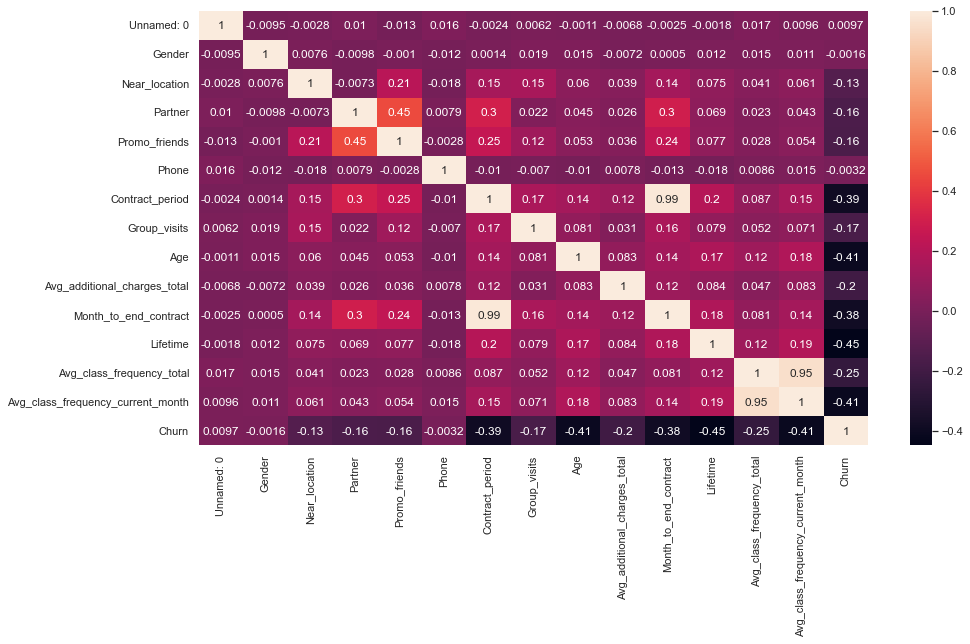

In [20]:
gm = gym_df.corr() # calculate correlation matrix
#fig, ax = plt.subplots()

# plot an annotated heatmap for the correlation matrix
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(gm,annot=True)# write your code here
#ax.set_ylim(20, 0) # correcting "ragged" heatmap fields in the latest version of the library

plt.show()

***Contract_period,month_to_end_contract and Avg_class_frequency_total,Avg_class_frequency_current_month shows really   
strong correlation.Since we don't consider linear models , we proceed further ..  
We dont see any feature exhibiting strong correlation with our target - churn..***

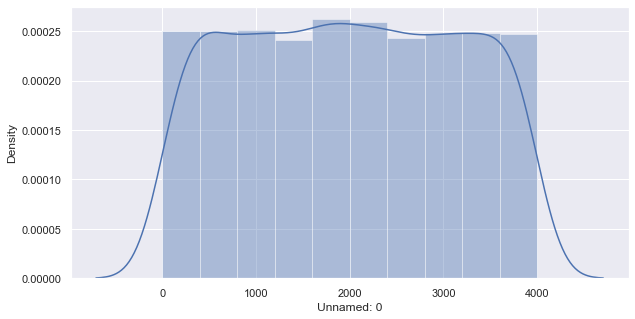

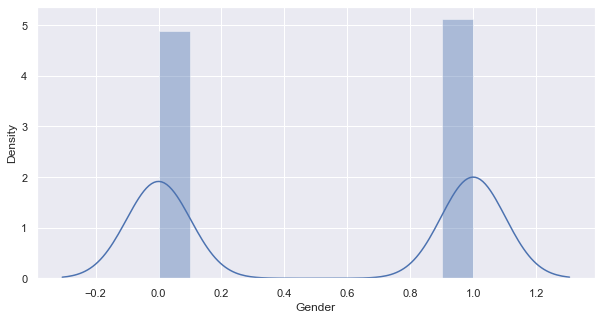

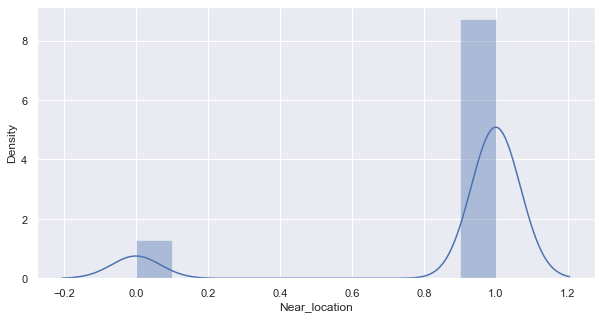

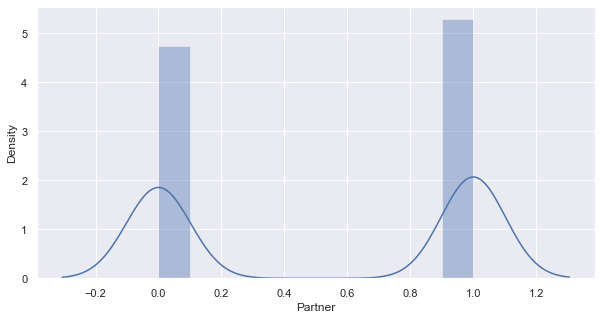

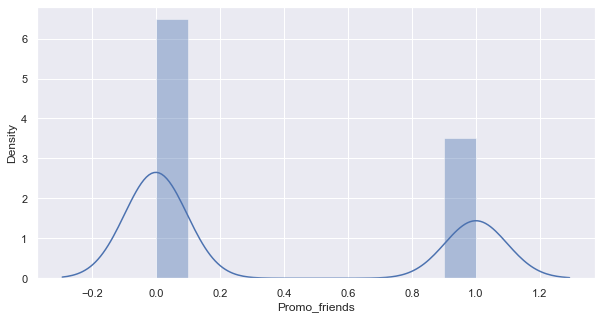

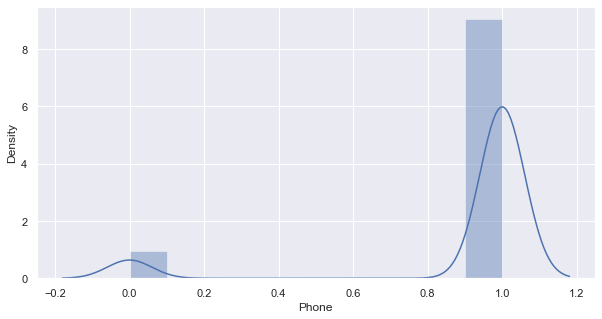

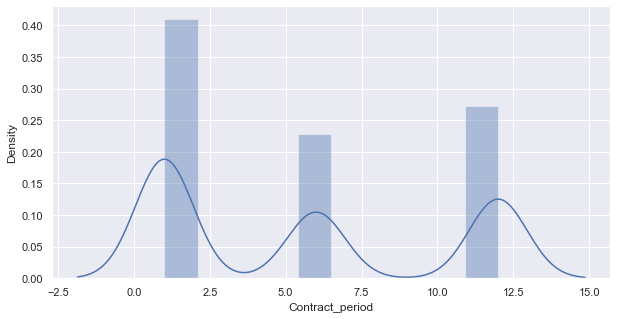

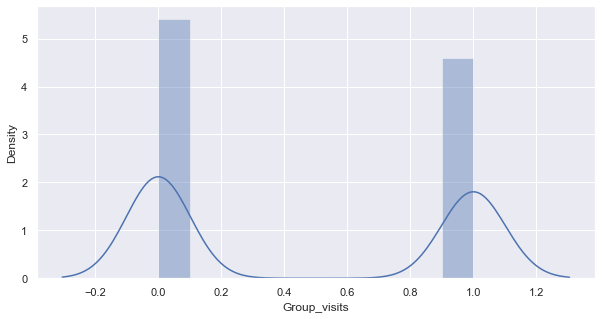

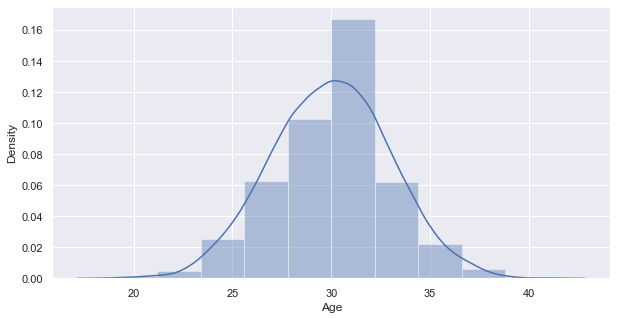

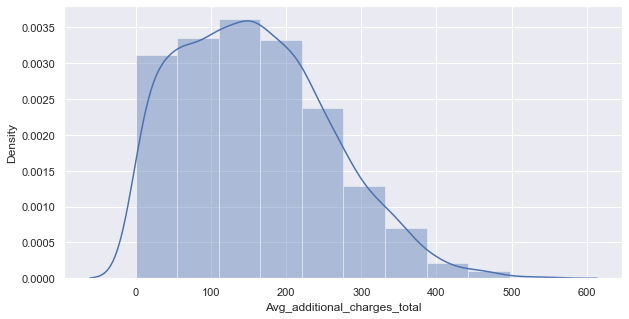

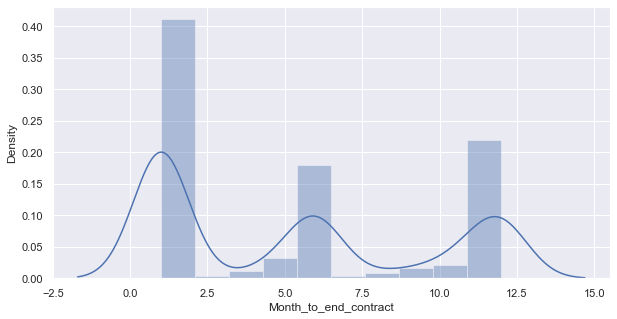

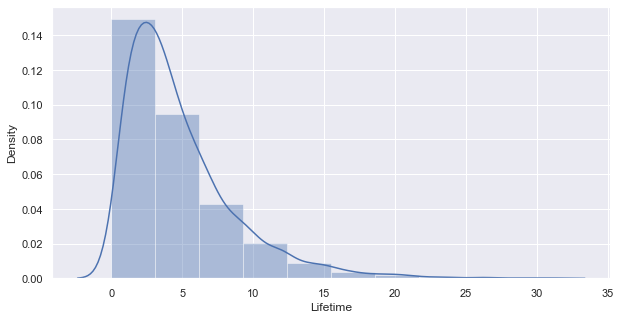

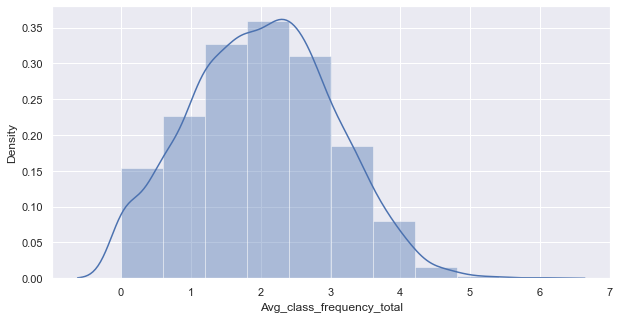

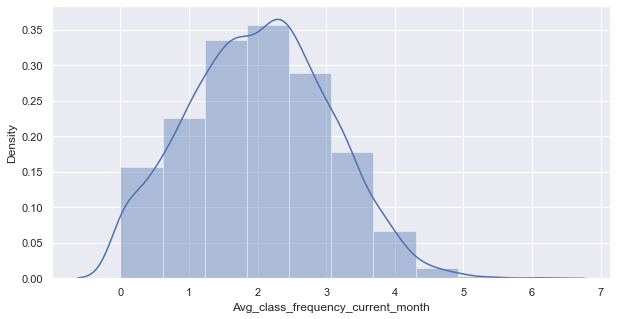

In [21]:
#plotting the features for users_stayed 
for col in gym_stayed_df.drop('Churn', axis=1).columns:
    sns.set(rc = {'figure.figsize':(10,5)})
    sns.distplot(gym_stayed_df[col], bins = 10)
    plt.show() 

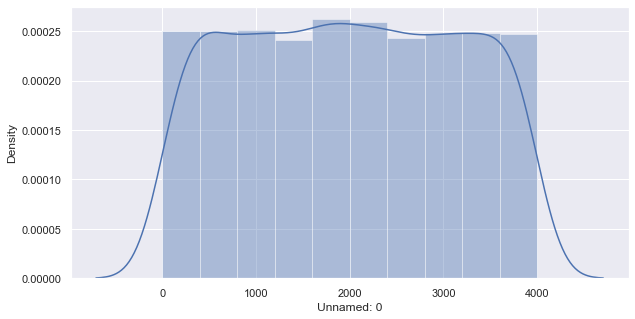

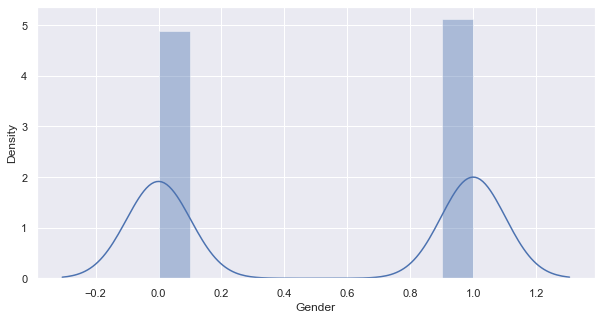

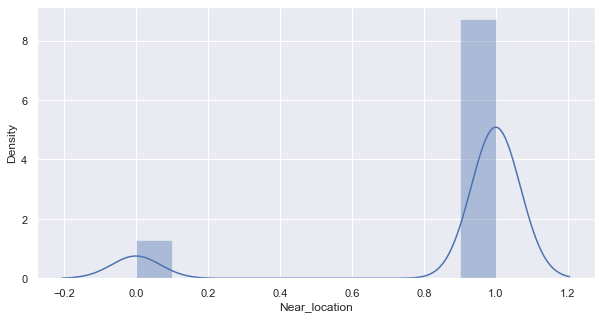

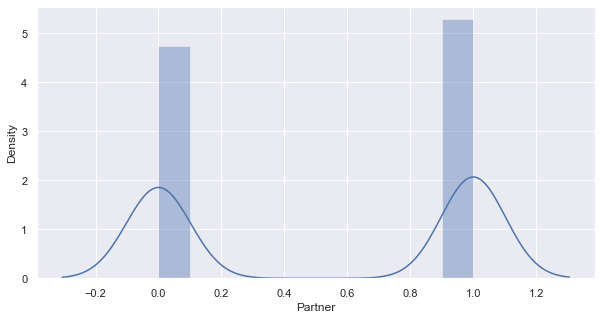

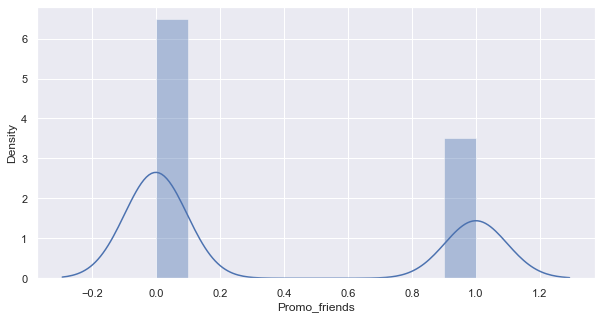

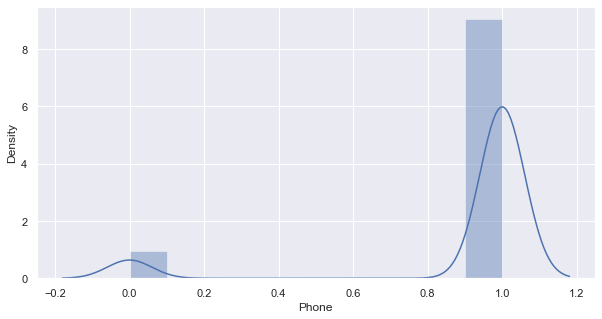

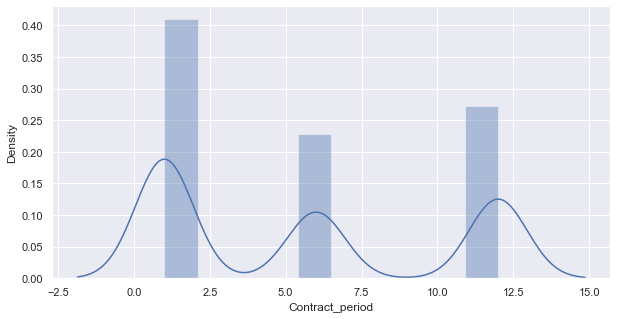

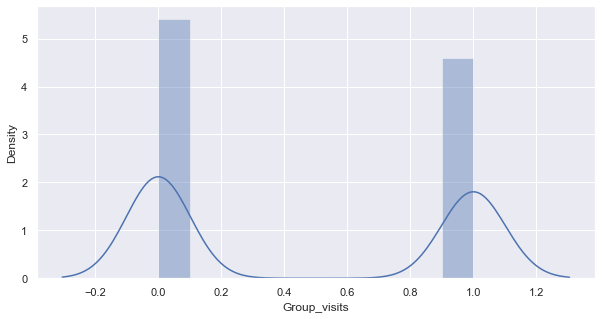

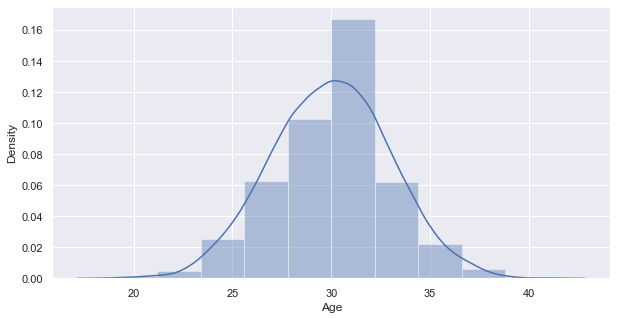

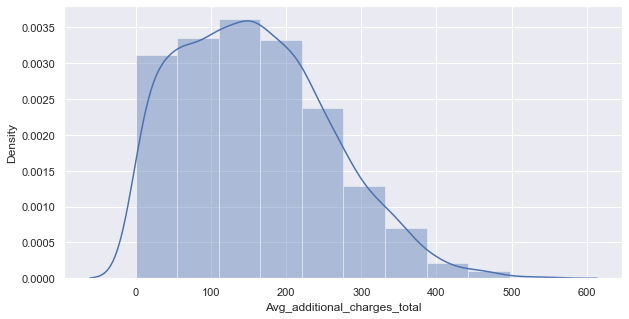

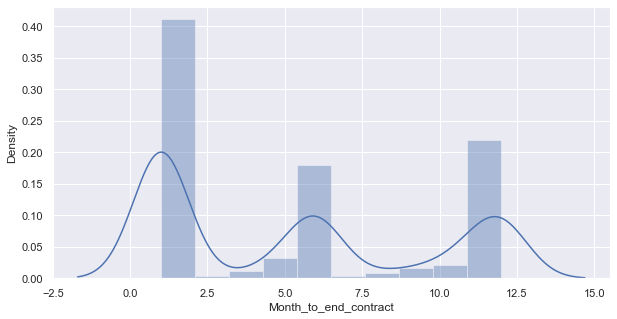

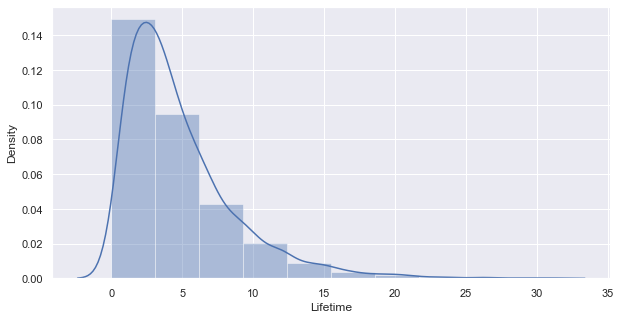

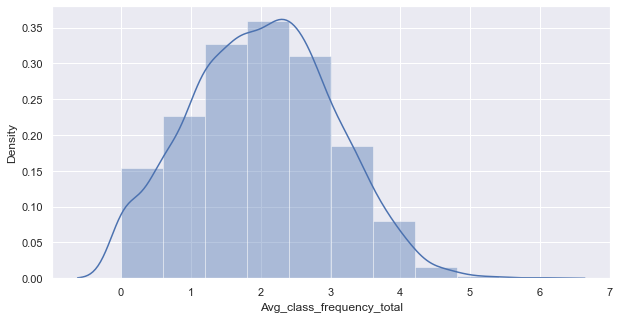

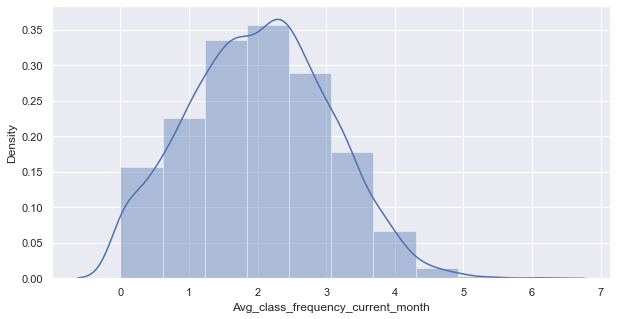

In [22]:
#plotting graphs for users_left
for col in gym_left_df.drop('Churn', axis=1).columns:
    sns.set(rc = {'figure.figsize':(10,5)})
    sns.distplot(gym_stayed_df[col], bins = 10)
    plt.show() 

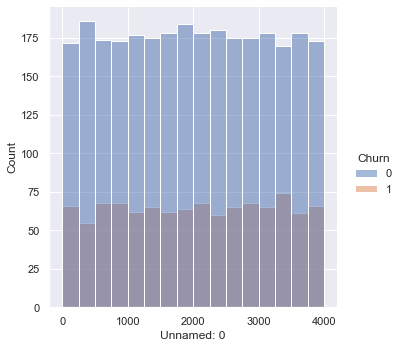

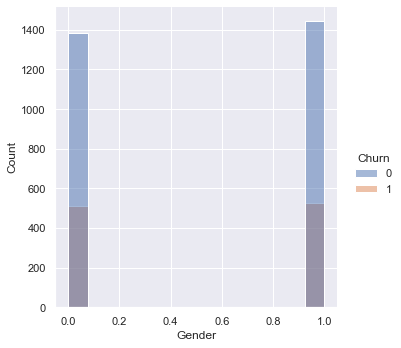

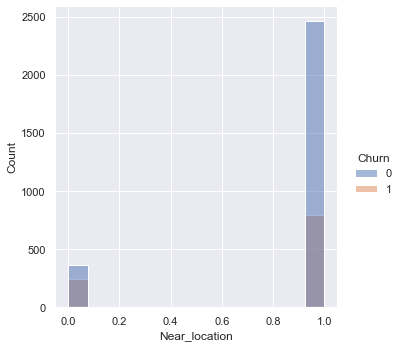

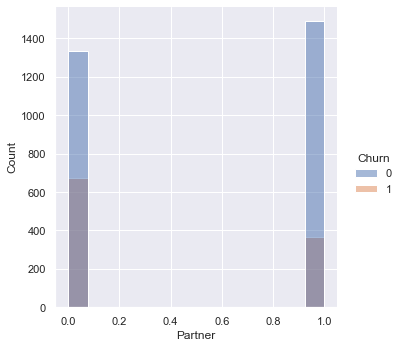

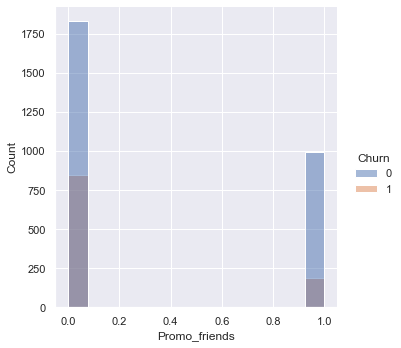

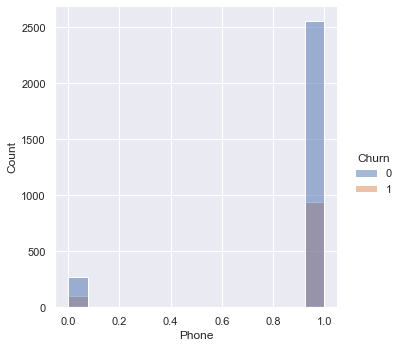

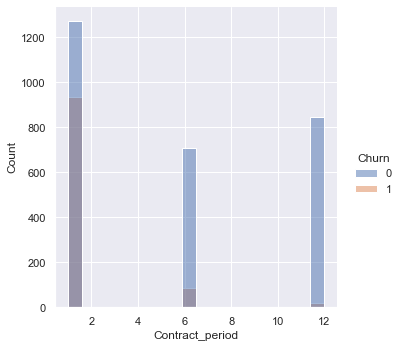

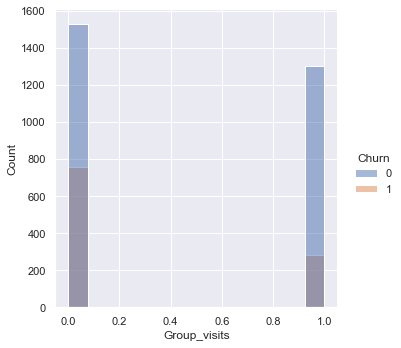

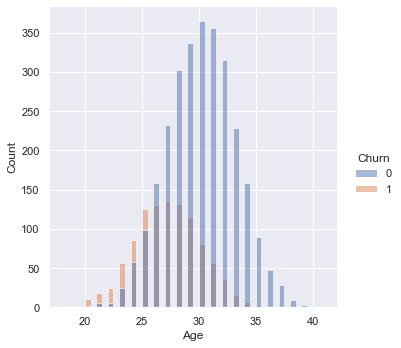

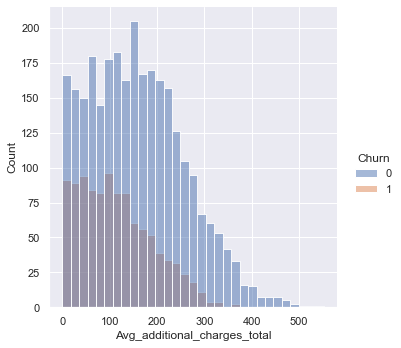

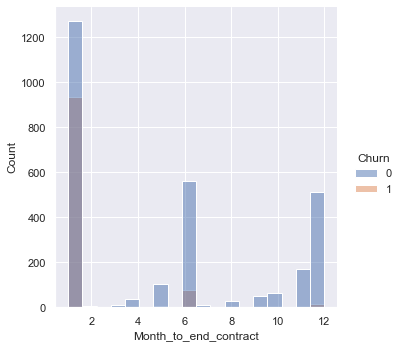

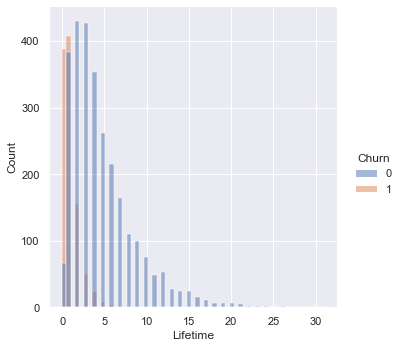

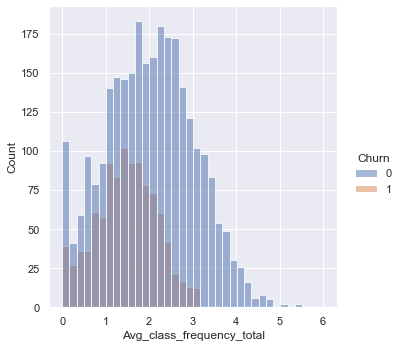

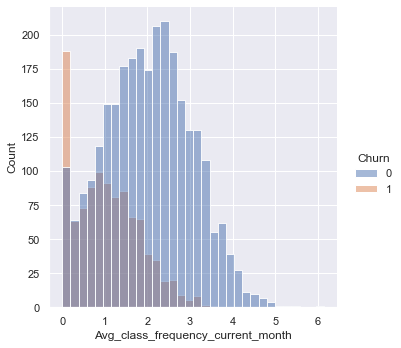

In [23]:
for col in gym_df.drop('Churn', axis=1).columns:
    sns.set(rc = {'figure.figsize':(10,5)})
    sns.displot(gym_df, x=col, hue=gym_df['Churn'])
    plt.show()

In [24]:
#Look at the mean feature values in two groups:
gym_df.groupby('Churn')['Age','Avg_additional_charges_total','Avg_class_frequency_total','Avg_class_frequency_current_month'].mean().reset_index()

,Churn,Age,Avg_additional_charges_total,Avg_class_frequency_total,Avg_class_frequency_current_month
0,0,29.985138,158.419493,2.018520,2.021157
1,1,26.995178,114.568700,1.471957,1.041986


In [25]:
gym_df.groupby('Churn').mean().reset_index()

,Churn,Unnamed: 0,Gender,Near_location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
0,0,1994.456476,0.510970,0.871550,0.527247,0.352088,0.903751,5.543878,0.460014,29.985138,158.419493,5.224345,4.830502,2.018520,2.021157
1,1,2019.694311,0.509161,0.767599,0.351013,0.181292,0.901639,1.600771,0.270974,26.995178,114.568700,1.579556,1.002893,1.471957,1.041986


***Looking at the users stayed group , we see the users age is around 30yrs and they spend comparatively more money though fewer classes in presence.***

[Back to Contents](#back)

<a id='logistic'>

# Build Logistic Regression model:

In [26]:
# divide the data into features (the X matrix) and a target variable (y)
X = gym_df.drop('Churn', axis = 1)
y = gym_df['Churn']

# divide the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# train StandardScaler on the train set
scaler = StandardScaler()
scaler.fit(X_train)

# transform train and test sets
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# define the model's algorithm 
lr_model = LogisticRegression(random_state=0)

# train your model
lr_model.fit(X_train_st,y_train)

# use the trained model to make forecasts
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st) [:,1]

<a id='random'>

# Build Random Forest Model

In [27]:
# define the model's algorithm  --Random forest
rf_model = RandomForestClassifier(random_state=0)

# train your model
rf_model.fit(X_train,y_train)

# use the trained model to make forecasts
rf_predictions = rf_model.predict(X_test)#updated
rf_probabilities =rf_model.predict_proba(X_test) [:,1]#updated

<a id='metrics'>

# Metrics

In [28]:
# define the function that will output our metrics
def print_all_metrics(y_true, y_pred, y_proba, title = 'Classification metrics'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    

In [29]:
print_all_metrics(y_test, lr_predictions, lr_probabilities , title='Metrics for logistic regression:')


Metrics for logistic regression:
	Accuracy: 0.94
	Precision: 0.90
	Recall: 0.86


In [30]:
print_all_metrics(y_test, rf_predictions,rf_probabilities , title='Metrics for random forest:')


Metrics for random forest:
	Accuracy: 0.94
	Precision: 0.91
	Recall: 0.87


***Logistic regression and random forest show similar results in terms of accuracy and percision and  
recall value..(based on updated random forest model)***

[Back to Contents](#back)

<a id='hierarchial'>

# Agglomerative Hierarchial Clustering

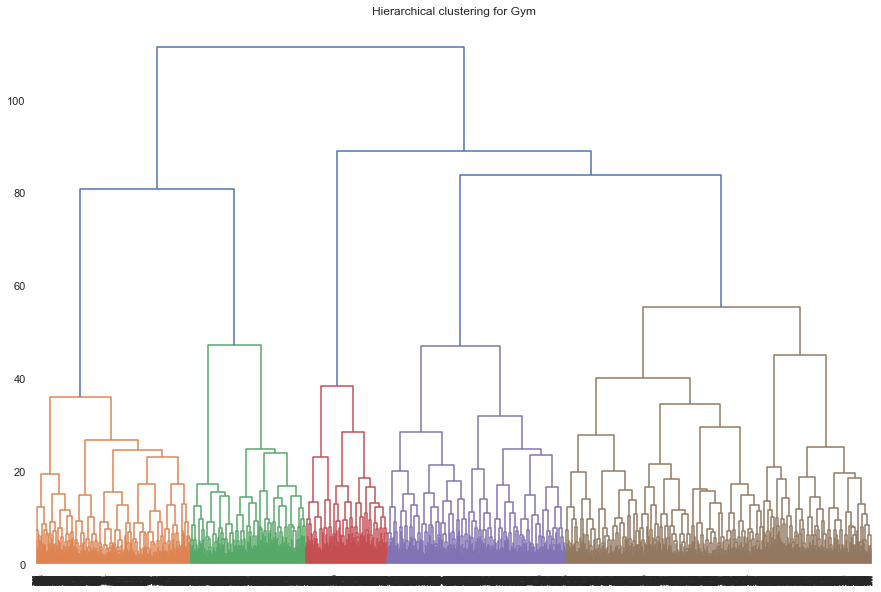

In [31]:
#First we will find the number of clusters using heirarchial clustering.
x_set = scaler.fit_transform(gym_df)
linked = linkage(x_set, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchical clustering for Gym')
plt.show() 

***The suggested optimal number of clusters (5) corresponds to the five different colors on the plot.***

[Back to Contents](#back)

<a id='kmeans'>

# K Means Clustering

In [34]:
#kmeans algorithm
km = KMeans(n_clusters = 5,random_state=0)#updated with random_state
labels = km.fit_predict(x_set)

In [35]:
gym_df['cluster_number']=labels

In [36]:
print(gym_df.groupby(['cluster_number'])['Age','Avg_additional_charges_total','Month_to_end_contract','Avg_class_frequency_total','Avg_class_frequency_current_month'].mean())

                      Age  Avg_additional_charges_total  \
cluster_number                                            
0               29.903333                    162.443111   
1               30.009524                    159.317548   
2               26.928183                    114.750051   
3               30.008393                    153.591254   
4               29.289189                    143.041313   

                Month_to_end_contract  Avg_class_frequency_total  \
cluster_number                                                     
0                           10.390000                   2.000276   
1                            2.439286                   2.909735   
2                            1.443961                   1.447416   
3                            2.455635                   1.167392   
4                            4.397297                   1.844728   

                Avg_class_frequency_current_month  
cluster_number                                     
0    

In [37]:
#mean value of all the features
print(gym_df.groupby(['cluster_number']).mean())

                 Unnamed: 0    Gender  Near_location   Partner  Promo_friends  \
cluster_number                                                                  
0               2011.650000  0.504444       0.938889  0.761111       0.568889   
1               2045.716667  0.548810       0.838095  0.371429       0.214286   
2               2045.810664  0.507073       0.761697  0.337323       0.178455   
3               1920.399281  0.473621       0.827338  0.449640       0.255396   
4               1946.370270  0.529730       0.864865  0.464865       0.308108   

                   Phone  Contract_period  Group_visits        Age  \
cluster_number                                                       
0               0.997778        11.093333      0.555556  29.903333   
1               0.998810         2.557143      0.433333  30.009524   
2               0.998912         1.458107      0.260065  26.928183   
3               1.000000         2.579137      0.388489  30.008393   
4           

In [38]:
# define the function for rendering graphs of paired features for the clusters
def show_clusters_on_plot(df, x_name,y_name, cluster_name):
    plt.figure(figsize = (10,10))
    sns.scatterplot(df[x_name], df[y_name],
          hue = df[cluster_name], palette = 'Paired'
       )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()

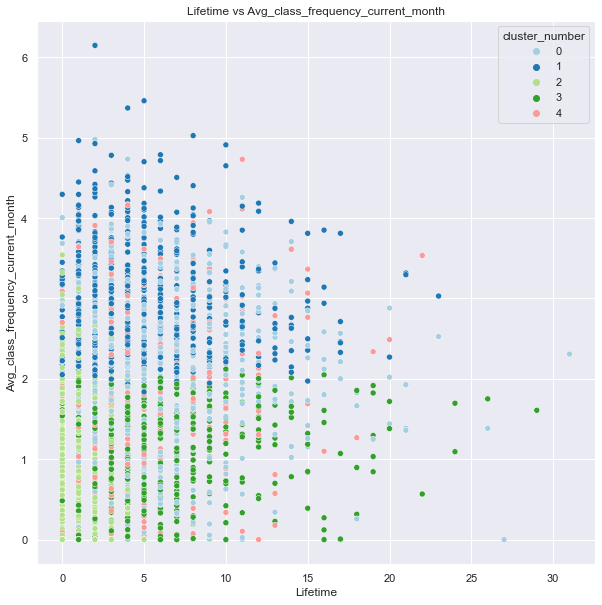

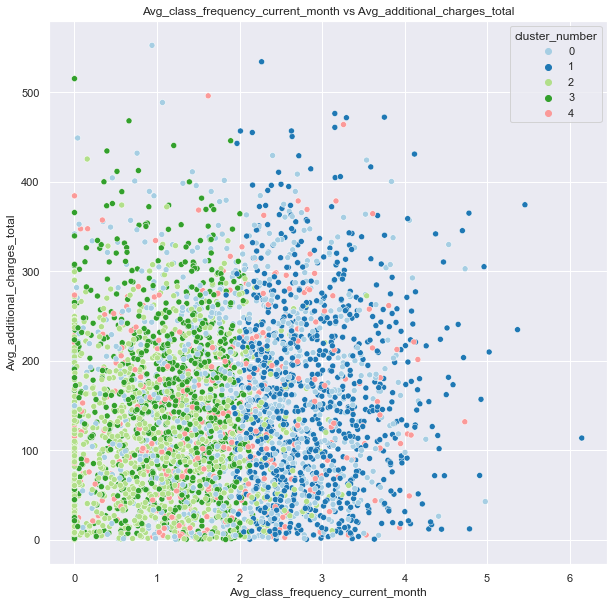

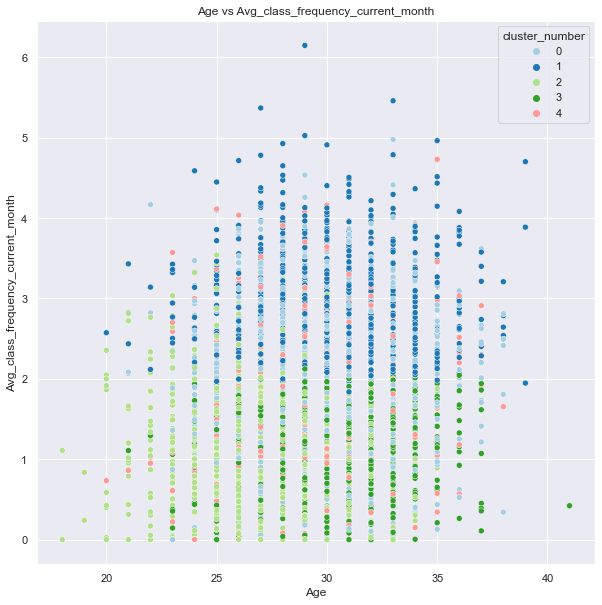

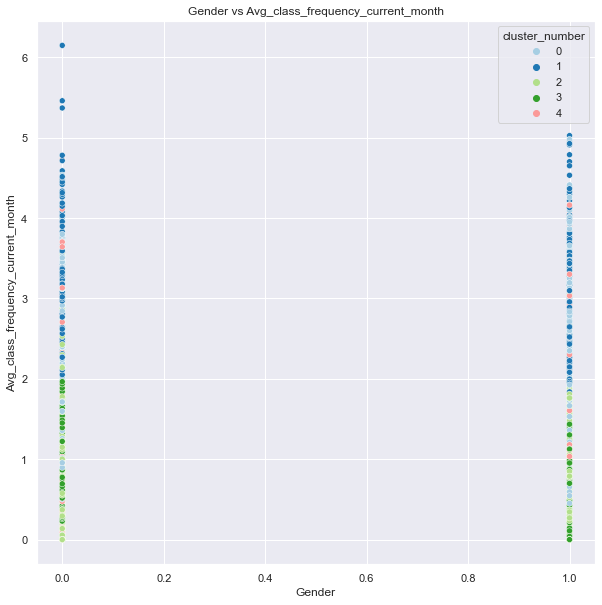

In [39]:
show_clusters_on_plot(gym_df, 'Lifetime','Avg_class_frequency_current_month','cluster_number')
show_clusters_on_plot(gym_df, 'Avg_class_frequency_current_month','Avg_additional_charges_total','cluster_number')
show_clusters_on_plot(gym_df, 'Age','Avg_class_frequency_current_month','cluster_number')
show_clusters_on_plot(gym_df, 'Gender','Avg_class_frequency_current_month','cluster_number')

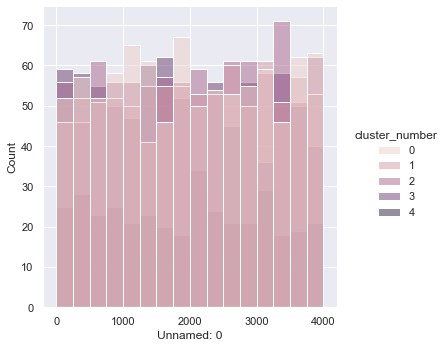

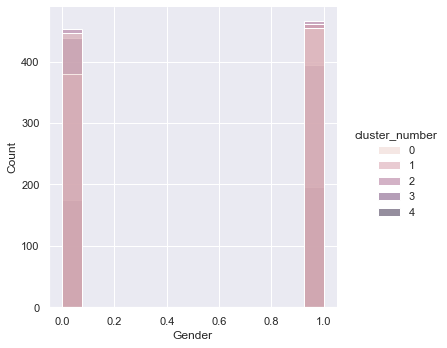

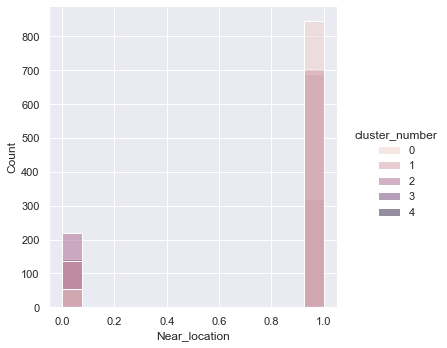

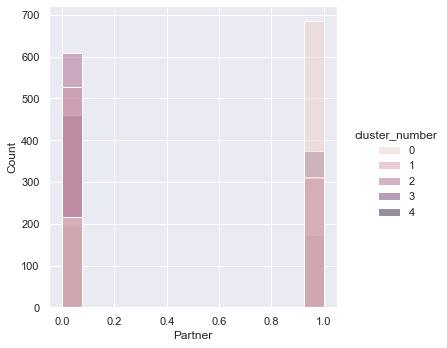

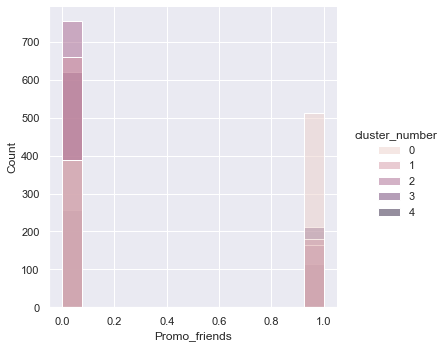

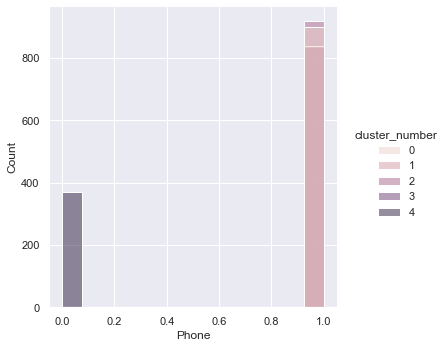

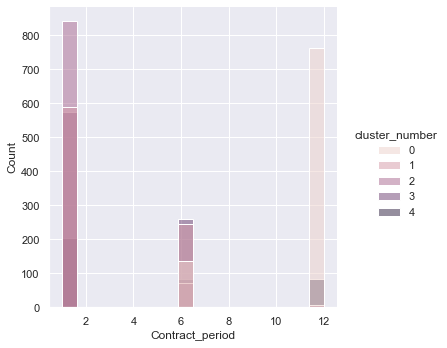

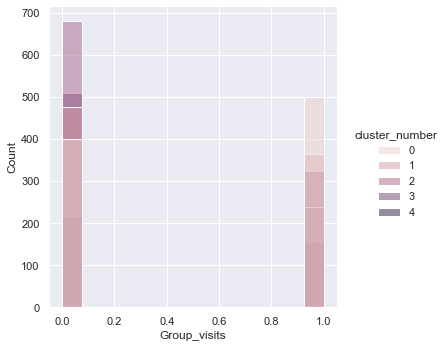

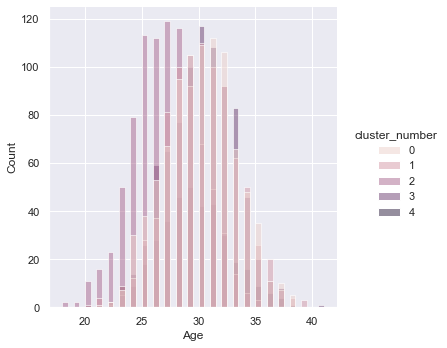

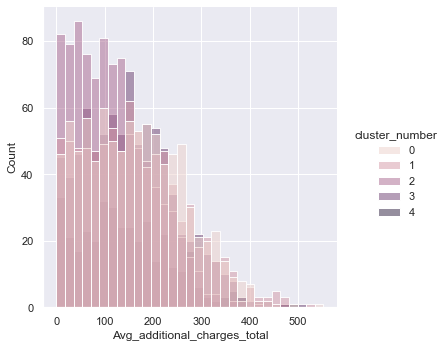

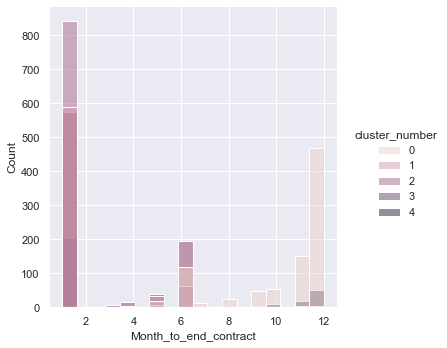

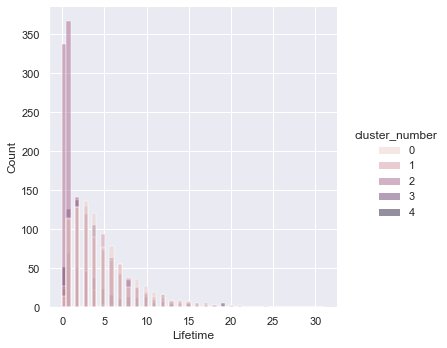

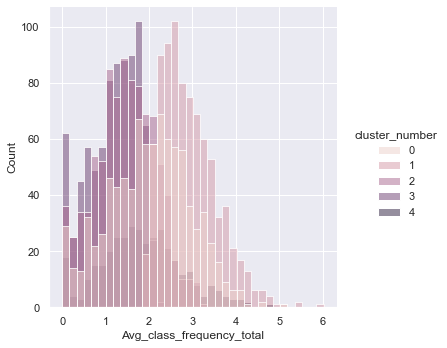

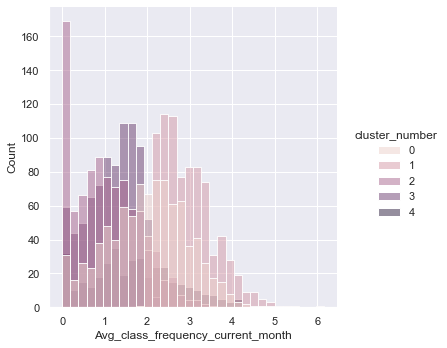

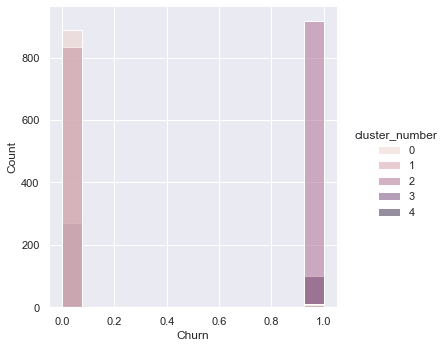

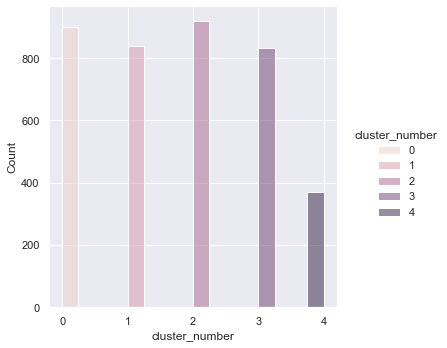

In [40]:
#feature distribution among clusters
for col in gym_df.columns:
    sns.displot(gym_df, x=col, hue=gym_df['cluster_number'])
    plt.show()

[Back to Contents](#back)

<a id='churnrate'>

# Churn rate

In [41]:
gym_churn_rate_df=gym_df.groupby('cluster_number').agg({'Churn': ['sum', 'count']}).reset_index()

In [42]:
gym_churn_rate_df.columns=['cluster_number','users_left','total_users']
gym_churn_rate_df

,cluster_number,users_left,total_users
0,0,12,900
1,1,6,840
2,2,917,919
3,3,1,834
4,4,101,370


In [43]:
gym_churn_rate_df['churn_rate(%)']=gym_churn_rate_df['users_left']/gym_churn_rate_df['total_users']*100
gym_churn_rate_df['churn_rate(%)']=gym_churn_rate_df['churn_rate(%)'].astype('int')
gym_churn_rate_df

,cluster_number,users_left,total_users,churn_rate(%)
0,0,12,900,1
1,1,6,840,0
2,2,917,919,99
3,3,1,834,0
4,4,101,370,27


***Clusters 2 and 3 have almost all the users intact with 0 churn rate followed by cluster 0 with just 1%.  
Cluster 4 has highest churn rate with almost all the uses leaving followed by cluster 1 with 27% churn rate.***

In [44]:
gym_df[gym_df['cluster_number']==0].describe()

,Unnamed: 0,Gender,Near_location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn,cluster_number
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.0
mean,2011.650000,0.504444,0.938889,0.761111,0.568889,0.997778,11.093333,0.555556,29.903333,162.443111,10.390000,5.034444,2.000276,1.995164,0.013333,0.0
std,1154.909493,0.500258,0.239667,0.426642,0.495507,0.047114,2.150138,0.497180,3.072826,101.077299,2.293316,4.027703,0.932956,0.934447,0.114761,0.0
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,21.000000,0.251606,2.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,1029.500000,0.000000,1.000000,1.000000,0.000000,1.000000,12.000000,0.000000,28.000000,78.205870,9.000000,2.000000,1.344532,1.359308,0.000000,0.0
50%,1968.500000,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,30.000000,157.417036,12.000000,4.000000,2.046327,2.047743,0.000000,0.0
75%,3018.000000,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,32.000000,235.820838,12.000000,7.000000,2.659778,2.659560,0.000000,0.0
max,3998.000000,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,38.000000,552.590740,12.000000,31.000000,5.079242,4.976680,1.000000,0.0


In [45]:
gym_df[gym_df['cluster_number']==1].describe()

,Unnamed: 0,Gender,Near_location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn,cluster_number
count,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.0
mean,2045.716667,0.548810,0.838095,0.371429,0.214286,0.998810,2.557143,0.433333,30.009524,159.317548,2.439286,4.633333,2.909735,2.916872,0.007143,1.0
std,1152.262333,0.497908,0.368583,0.483475,0.410570,0.034503,2.448822,0.495831,3.083256,103.194719,2.259902,3.578686,0.635889,0.639289,0.084263,0.0
min,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,20.000000,0.362153,1.000000,0.000000,1.875933,1.837224,0.000000,1.0
25%,1019.750000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,28.000000,75.403903,1.000000,2.000000,2.416770,2.414453,0.000000,1.0
50%,2064.500000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,30.000000,148.340741,1.000000,4.000000,2.792621,2.809752,0.000000,1.0
75%,3060.750000,1.000000,1.000000,1.000000,0.000000,1.000000,6.000000,1.000000,32.000000,226.461028,5.000000,6.000000,3.296336,3.316208,0.000000,1.0
max,3989.000000,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,39.000000,534.256182,11.000000,23.000000,6.023668,6.146783,1.000000,1.0


In [46]:
gym_df[gym_df['cluster_number']==2].describe()

,Unnamed: 0,Gender,Near_location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn,cluster_number
count,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.000000,919.0
mean,2045.810664,0.507073,0.761697,0.337323,0.178455,0.998912,1.458107,0.260065,26.928183,114.750051,1.443961,0.991295,1.447416,1.026328,0.997824,2.0
std,1154.136082,0.500222,0.426277,0.473054,0.383104,0.032987,1.585658,0.438909,2.905044,78.193573,1.542733,1.055090,0.685854,0.760179,0.046625,0.0
min,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000,2.0
25%,1050.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,25.000000,50.238074,1.000000,0.000000,0.994664,0.402297,1.000000,2.0
50%,2076.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,104.268310,1.000000,1.000000,1.467077,0.951705,1.000000,2.0
75%,3051.500000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,29.000000,165.391763,1.000000,1.000000,1.931753,1.566481,1.000000,2.0
max,3996.000000,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,35.000000,425.535220,12.000000,9.000000,3.188502,3.540271,1.000000,2.0


In [47]:
gym_df[gym_df['cluster_number']==3].describe()

,Unnamed: 0,Gender,Near_location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn,cluster_number
count,834.000000,834.000000,834.000000,834.000000,834.000000,834.0,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.0
mean,1920.399281,0.473621,0.827338,0.449640,0.255396,1.0,2.579137,0.388489,30.008393,153.591254,2.455635,4.678657,1.167392,1.165185,0.001199,3.0
std,1146.260345,0.499603,0.378181,0.497756,0.436345,0.0,2.359440,0.487699,2.867406,93.768178,2.216076,4.004781,0.572717,0.571460,0.034627,0.0
min,2.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.000000,0.000000,21.000000,0.171862,1.000000,0.000000,0.000000,0.000000,0.000000,3.0
25%,937.500000,0.000000,1.000000,0.000000,0.000000,1.0,1.000000,0.000000,28.000000,79.551735,1.000000,2.000000,0.732680,0.749813,0.000000,3.0
50%,1874.500000,0.000000,1.000000,0.000000,0.000000,1.0,1.000000,0.000000,30.000000,146.919002,1.000000,4.000000,1.243644,1.244225,0.000000,3.0
75%,2874.750000,1.000000,1.000000,1.000000,1.000000,1.0,6.000000,1.000000,32.000000,212.232579,5.000000,6.000000,1.647948,1.633613,0.000000,3.0
max,3993.000000,1.000000,1.000000,1.000000,1.000000,1.0,12.000000,1.000000,41.000000,515.392606,11.000000,29.000000,2.189759,2.214583,1.000000,3.0


In [48]:
gym_df[gym_df['cluster_number']==4].describe()

,Unnamed: 0,Gender,Near_location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn,cluster_number
count,370.000000,370.000000,370.000000,370.000000,370.000000,370.0,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.0
mean,1946.370270,0.529730,0.864865,0.464865,0.308108,0.0,4.605405,0.416216,29.289189,143.041313,4.397297,3.932432,1.844728,1.706889,0.272973,4.0
std,1150.266363,0.499791,0.342331,0.499439,0.462337,0.0,4.479520,0.493598,3.138215,93.803228,4.261314,3.912772,0.930857,1.016616,0.446090,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,20.000000,1.767654,1.000000,0.000000,0.000000,0.000000,0.000000,4.0
25%,902.500000,0.000000,1.000000,0.000000,0.000000,0.0,1.000000,0.000000,27.000000,71.023921,1.000000,1.000000,1.206112,1.010004,0.000000,4.0
50%,2023.500000,1.000000,1.000000,0.000000,0.000000,0.0,1.000000,0.000000,29.000000,132.909336,1.000000,3.000000,1.811332,1.635158,0.000000,4.0
75%,2941.000000,1.000000,1.000000,1.000000,1.000000,0.0,6.000000,1.000000,31.000000,201.820004,6.000000,5.000000,2.390802,2.380092,1.000000,4.0
max,3999.000000,1.000000,1.000000,1.000000,1.000000,0.0,12.000000,1.000000,38.000000,496.172222,12.000000,22.000000,4.793780,4.729706,1.000000,4.0


***Cluster 2 and cluster 3 have more similarity from number of records to churn rate and feature details..The only difference  
is  average classes per week for entire lifetimde and current month is around 3 for cluster 2 and 1 for cluster 3.***

In [49]:
churned_df=gym_df[gym_df['cluster_number']==4]
stayed_df=gym_df[gym_df['cluster_number']==2]

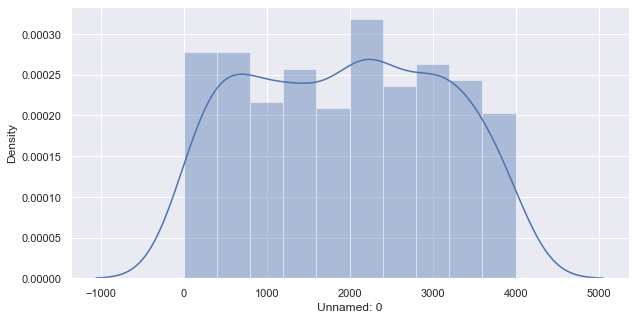

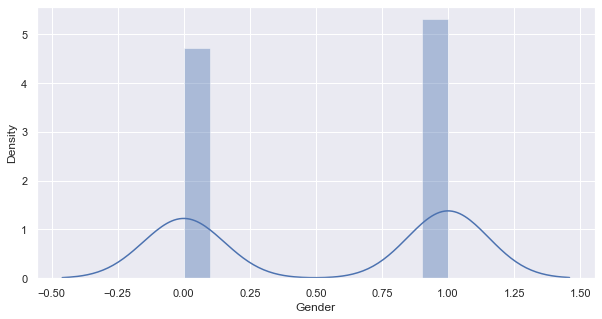

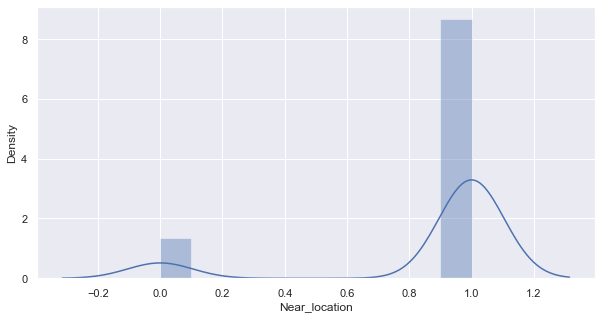

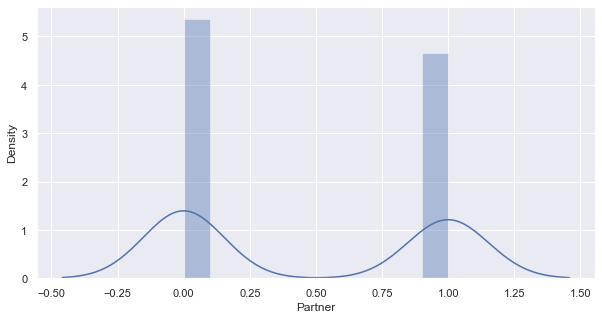

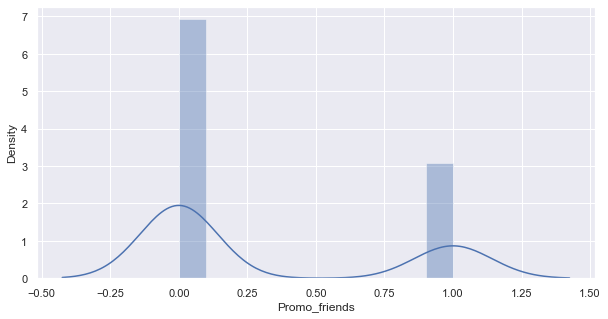

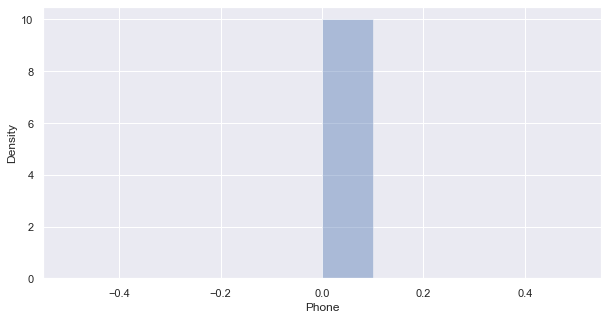

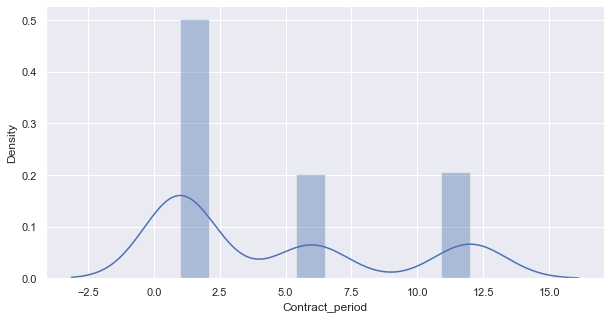

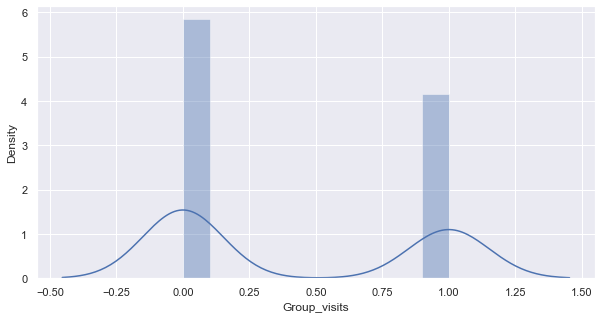

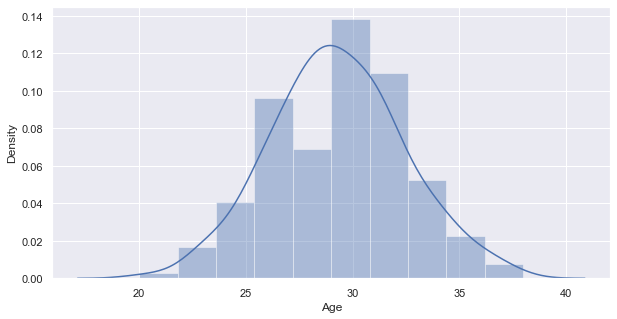

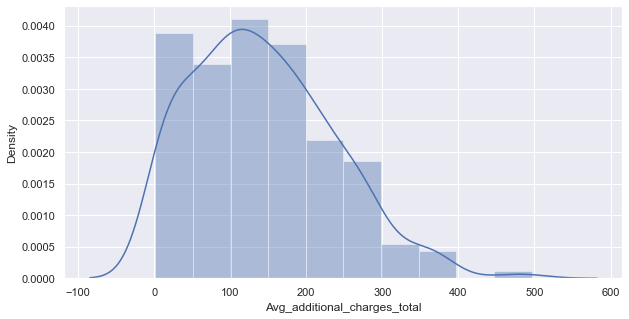

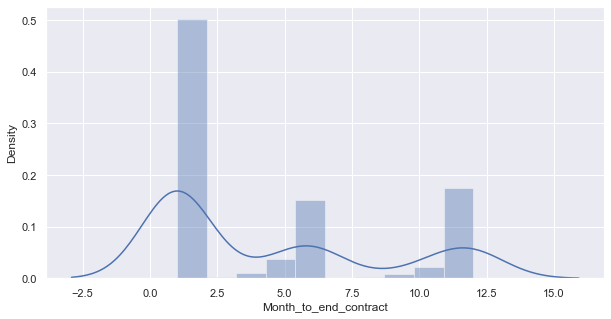

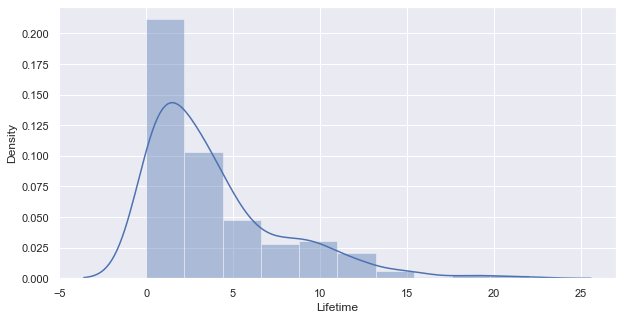

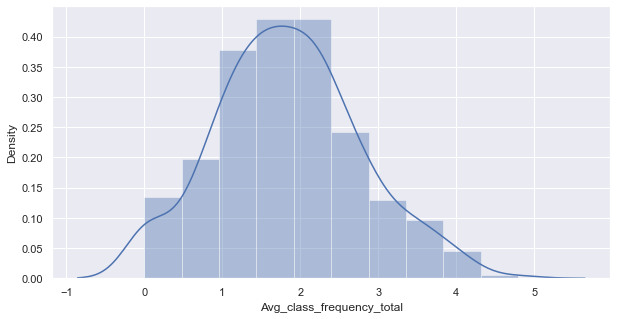

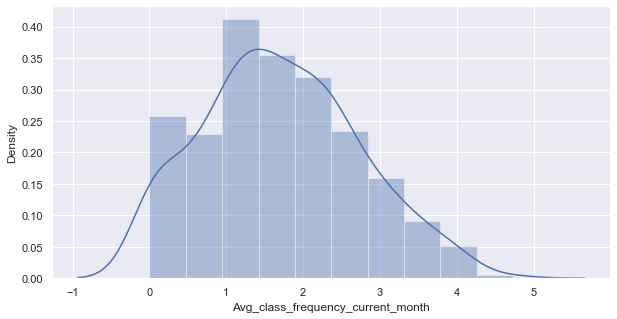

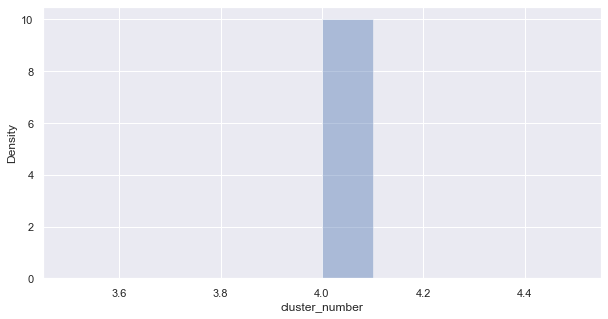

In [50]:
#plotting the features for users_churned cluster 
for col in churned_df.drop('Churn', axis=1).columns:
    sns.set(rc = {'figure.figsize':(10,5)})
    sns.distplot(churned_df[col], bins = 10)
    plt.show() 

***Analysing cluster 4 ,we see that it has users that stay nearby and are mostly like organic(not joined from partner company  
or friend promotion).These users typically average around 26yrs who spends more whenever they are in for a class..  
Also they mostly got for 1 month contract..***

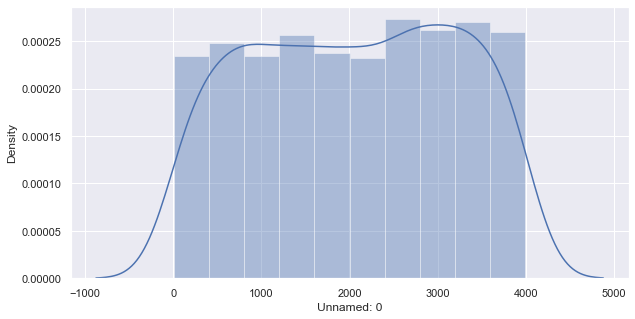

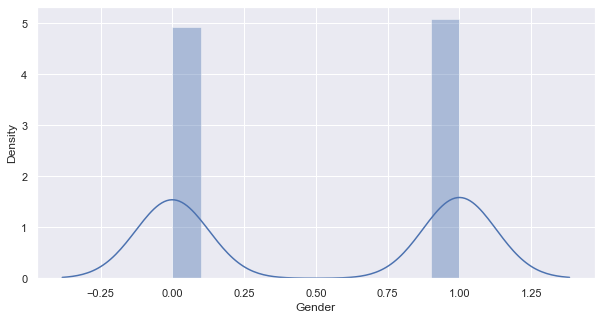

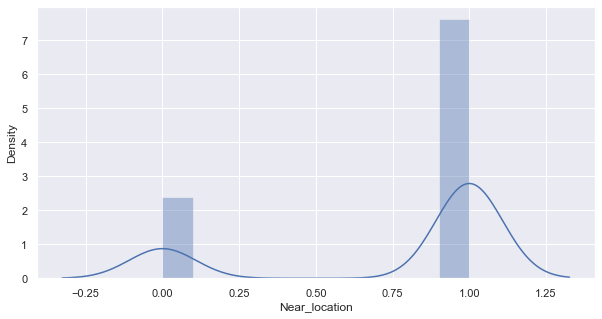

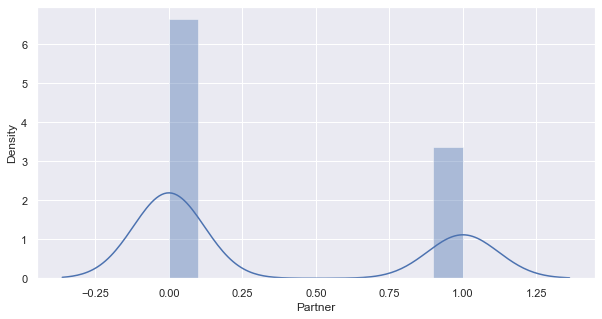

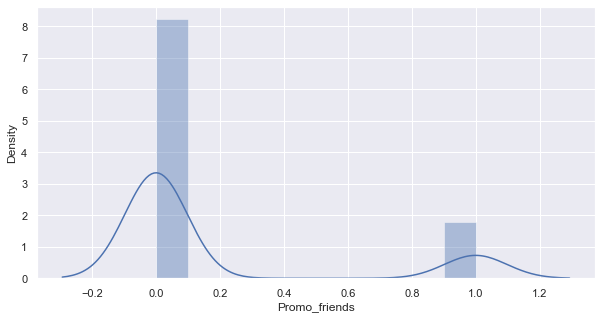

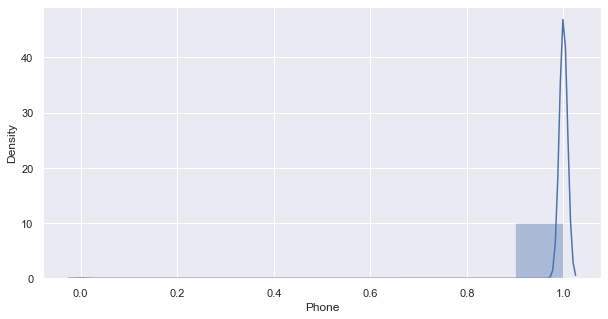

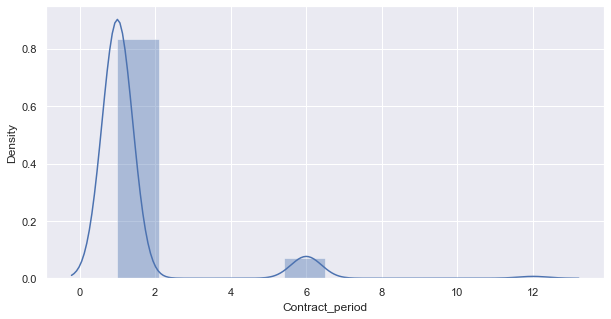

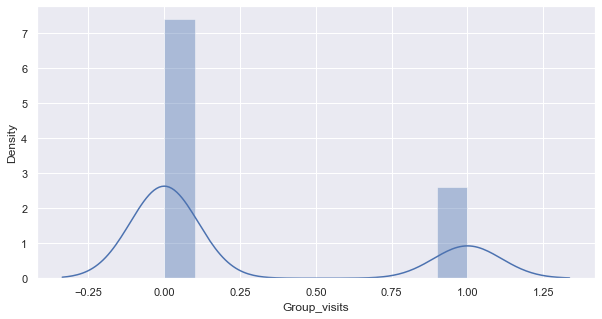

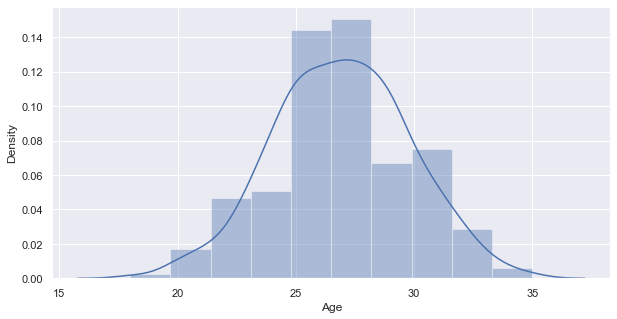

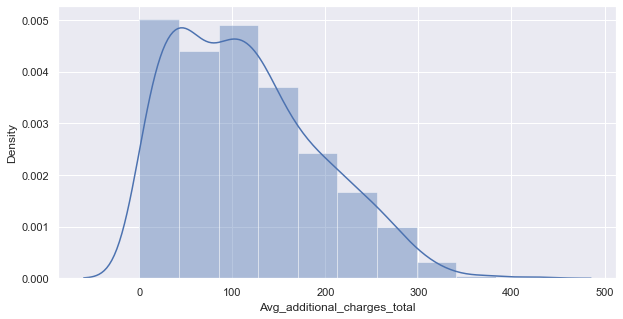

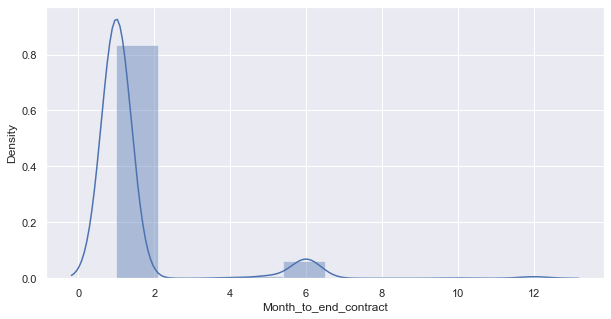

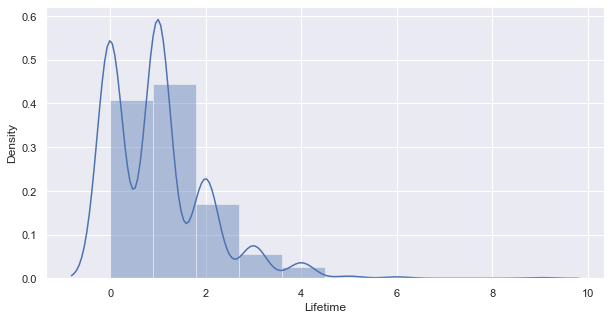

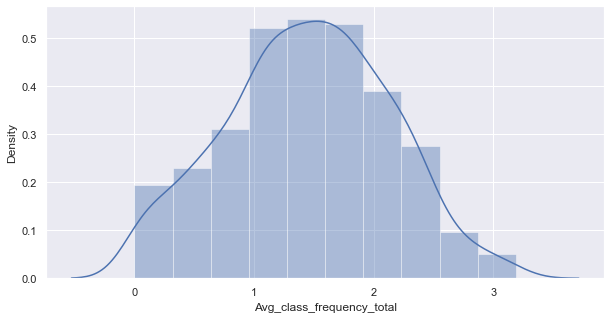

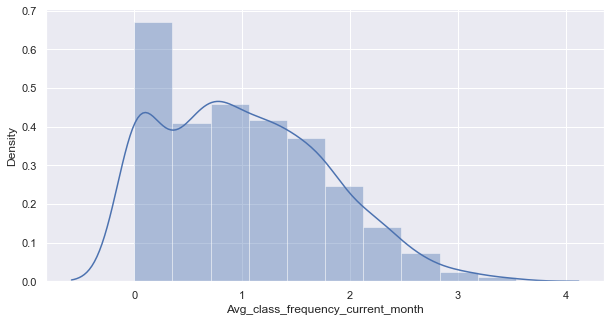

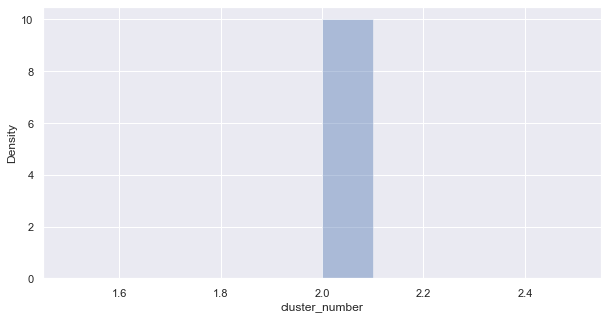

In [51]:
#plotting the features for users_stayed cluster
for col in stayed_df.drop('Churn', axis=1).columns:
    sns.set(rc = {'figure.figsize':(10,5)})
    sns.distplot(stayed_df[col], bins = 10)
    plt.show() 

***Looking at the cluster retaining almost all the users (cluster 2),we see that users average around 30yrs .  
Though most of the users prefer 1 month contract , we see sizeable people going for 6month contract thereby increasing lifetime.
With increased classes per week(2-3) throughout the lifetime ,cluster 2 has lost almost no users in the given month.***  

<a id='end'>

# Final Conclusion

1.Looking at the cluster retaining almost all the users (cluster 2),we see that users average around 30yrs .
Though most of the users prefer 1 month contract , we see sizeable people going for 6month contract thereby increasing lifetime. With increased classes per week(2-3) throughout the lifetime ,cluster 2 has lost almost no users in the given month.   
2.Analysing cluster 4 (most churned cluster),we see that it has users stay nearby and are mostly like organic(not joined from partner company  or friend promotion).These users typically average around 26yrs and spends more whenever they are in for a class..Also they mostly got for 1 month contract.

***RECOMMENDATION***  
1.Since we see that cluster 4 users have no issues with spending(we confirm from less users joining through partner/friend program and additional charges),we need to come up with more interesting options for them to choose from like  
some techy support ,cool gadgets..  
2.Most of the users have their phone number in the records , we can introduce some mobile app related promotions / upgrades to attract more users.  
3.As most users show interest for 1month contract , we can introduce something like 2month contract to give them option which  is not too longer..  
4.Also users in this cluster is younger compared to all other clusters ,which means we can introduce some more challenging/intense workout to satisfy the users.   
 
 Implementing changes  based on the above recommendation , will attract more users increasing the frequency of visits in a month to start with and increased lifetime finally along with more income from purchases and increased contract periods.

[Back to Contents](#back)